In [1]:
import numpy as np
from scipy.io import loadmat
from sklearn.linear_model import LogisticRegression as LR
import matplotlib.pyplot as plt
%matplotlib inline

# Theano imports
import theano
theano.config.floatX = 'float32'
import theano.tensor as T

# Plotting utility
from utils import tile_raster_images as tri

Using gpu device 0: Tesla K40c (CNMeM is enabled with initial size: 45.0% of memory, CuDNN 3007)


# The dataset
The dataset is the mnist digits which is a common toy data set for testing machine learning methods on images. This is a subset of the mnist set which have also been shrunked in size. Let's load them and plot some. In addition to the images, there are also the labels: 0-9 or even-odd.

Load the data.

In [2]:
data = loadmat('small_mnist.mat')

# Training data (images, 0-9, even-odd)
# Images are stored in a (batch, x, y) array
# Labels are integers
train_im = data['train_im']
train_y = data['train_y'].ravel()
train_eo = data['train_eo'].ravel()

# Validation data (images, 0-9, even-odd)
# Same format as training data
valid_im = data['valid_im']
valid_y = data['valid_y'].ravel()
valid_eo = data['valid_eo'].ravel()

Plot 10 of the training images. Rerun this cell to plot new images.

Labels: [0 7 6 3 1 5 8 7 9 4]
Odd-Even: [0 1 0 1 1 1 0 1 1 0]


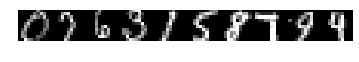

In [3]:
im_size = train_im.shape[-1]
order = np.random.permutation(train_im.shape[0])
ims = tri(train_im[order[:10]].reshape((-1, im_size**2)), (im_size, im_size), (1, 10), (1,1))
plt.imshow(ims, cmap='gray', interpolation='nearest')
plt.axis('off')
print('Labels: {}'.format(train_y[order[:10]]))
print('Odd-Even: {}'.format(train_eo[order[:10]]))

## Baseline linear classifier
Before we spend our precious time setting up and training deep networks on the data, let's see how a simple linear classifier from sklearn can do.

In [4]:
# Create the classifier to do multinomial classification
linear_classifier = LR(solver='lbfgs', multi_class='multinomial', C=0.1)

In [5]:
# Train and evaluate the classifier
linear_classifier.fit(train_im.reshape(-1, im_size**2), train_y)
print('Training Error on (0-9): {}'.format(linear_classifier.score(train_im.reshape(-1, im_size**2), train_y)))
print('Validation Error on (0-9): {}'.format(linear_classifier.score(valid_im.reshape(-1, im_size**2), valid_y)))

Training Error on (0-9): 0.914
Validation Error on (0-9): 0.899


Try training a linear classifier on the Even-Odd labels: train_eo!

# Using a Deep Nets library
If you're just starting off with deep nets and want to quickly try them on a dataset it is probably easiest to start with an existing library rather than writing your own. There are now a bunch of different libraries written for Python. We'll be using Keras which is designed to be easy to use. In matlab, there is the Neural Network Toolbox.

Keras documentation can be found here:
http://keras.io/

We'll do the next most complicated network comparer to linear regression: a two layer network!

In [6]:
# Import things from Keras Library
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D
from keras.regularizers import l2
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils

Using Theano backend.


## Fully connected MLP
This is a simple network made from two layers. On the Keras documentation page, you can find other nonlinearities under "Core Layers".

You can add more layers, changes the layers, change the optimizer, or add dropout.

In [7]:
# Create the network!
mlp = Sequential()

# First fully connected layer
mlp.add(Dense(im_size**2/2, input_shape=(im_size**2,), W_regularizer=l2(0.001))) # number of hidden units, default is 100
mlp.add(Activation('tanh')) # nonlinearity
print('Shape after layer 1: {}'.format(mlp.output_shape))

# Second fully connected layer with softmax output
mlp.add(Dropout(0.0)) # dropout is currently turned off, you may need to train for more epochs if nonzero
mlp.add(Dense(10)) # number of targets, 10 for y, 2 for eo
mlp.add(Activation('softmax'))

# Adam is a simple optimizer, SGD has more parameters and is slower but may give better results
opt = Adam()
#opt = RMSprop()
#opt = SGD(lr=0.1, momentum=0.9, decay=0.0001, nesterov=True)
print('')
mlp.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
mlp.fit(train_im.reshape(-1, im_size**2), np_utils.to_categorical(train_y), nb_epoch=20, batch_size=100)
tr_score = mlp.evaluate(train_im.reshape(-1, im_size**2), np_utils.to_categorical(train_y), batch_size=100)
va_score = mlp.evaluate(valid_im.reshape(-1, im_size**2), np_utils.to_categorical(valid_y), batch_size=100)
print('')
print('Train loss: {}, train accuracy: {}'.format(*tr_score))
print('Validation loss: {}, validation accuracy: {}'.format(*va_score))

Shape after layer 1: (None, 50)

Epoch 1/20
10000/10000 [==============================] - 0s - loss: 1.5874 - acc: 0.5948     
Epoch 2/20
10000/10000 [==============================] - 0s - loss: 0.8247 - acc: 0.8305     
Epoch 3/20
10000/10000 [==============================] - 0s - loss: 0.6166 - acc: 0.8693     
Epoch 4/20
10000/10000 [==============================] - 0s - loss: 0.5266 - acc: 0.8881     
Epoch 5/20
10000/10000 [==============================] - 0s - loss: 0.4770 - acc: 0.9002     
Epoch 6/20
10000/10000 [==============================] - 0s - loss: 0.4457 - acc: 0.9036     
Epoch 7/20
10000/10000 [==============================] - 0s - loss: 0.4227 - acc: 0.9076     
Epoch 8/20
10000/10000 [==============================] - 0s - loss: 0.4061 - acc: 0.9121     
Epoch 9/20
10000/10000 [==============================] - 0s - loss: 0.3920 - acc: 0.9147     
Epoch 10/20
10000/10000 [==============================] - 0s - loss: 0.3802 - acc: 0.9169     
Epoch 11/20
1000

## Convolutional MLP
We can also have the first layer be a set of small filters which are convolved with the images.

Try different parameters and see what happens. (This network might be slow.)

In [8]:
# Create the network!
cnn = Sequential()

# First fully connected layer
cnn.add(Convolution2D(20, 5, 5, input_shape=(1, im_size, im_size), border_mode='valid', subsample=(2, 2)))
cnn.add(Activation('tanh')) # nonlinearity
print('Shape after layer 1: {}'.format(cnn.output_shape))

# Take outputs and turn them into a vector
cnn.add(Flatten())
print('Shape after flatten: {}'.format(cnn.output_shape))

# Fully connected layer
cnn.add(Dropout(0.0)) # dropout is currently turned off, you may need to train for more epochs if nonzero
cnn.add(Dense(100)) # number of targets, 10 for y, 2 for eo
cnn.add(Activation('tanh'))

# Second fully connected layer with softmax output
cnn.add(Dropout(0.0)) # dropout is currently turned off, you may need to train for more epochs if nonzero
cnn.add(Dense(10)) # number of targets, 10 for y, 2 for eo
cnn.add(Activation('softmax'))

# Adam is a simple optimizer, SGD has more parameters and is slower but may give better results
#opt = Adam()
#opt = RMSprop()
opt = SGD(lr=0.1, momentum=0.9, decay=0.0001, nesterov=True)
print('')
cnn.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
cnn.fit(train_im[:, np.newaxis, ...], np_utils.to_categorical(train_y), nb_epoch=20, batch_size=100)
tr_score = cnn.evaluate(train_im[:, np.newaxis, ...], np_utils.to_categorical(train_y), batch_size=100)
va_score = cnn.evaluate(valid_im[:, np.newaxis, ...], np_utils.to_categorical(valid_y), batch_size=100)
print('')
print('Train loss: {}, train accuracy: {}'.format(*tr_score))
print('Validation loss: {}, validation accuracy: {}'.format(*va_score))

Shape after layer 1: (None, 20, 3, 3)
Shape after flatten: (None, 180)

Epoch 1/20
10000/10000 [==============================] - 0s - loss: 0.5285 - acc: 0.8399     
Epoch 2/20
10000/10000 [==============================] - 0s - loss: 0.2627 - acc: 0.9228     
Epoch 3/20
10000/10000 [==============================] - 0s - loss: 0.1971 - acc: 0.9410     
Epoch 4/20
10000/10000 [==============================] - 0s - loss: 0.1541 - acc: 0.9546     
Epoch 5/20
10000/10000 [==============================] - 0s - loss: 0.1265 - acc: 0.9624     
Epoch 6/20
10000/10000 [==============================] - 0s - loss: 0.1015 - acc: 0.9710     
Epoch 7/20
10000/10000 [==============================] - 0s - loss: 0.0865 - acc: 0.9755     
Epoch 8/20
10000/10000 [==============================] - 0s - loss: 0.0735 - acc: 0.9793     
Epoch 9/20
10000/10000 [==============================] - 0s - loss: 0.0594 - acc: 0.9843     
Epoch 10/20
10000/10000 [==============================] - 0s - loss: 0.0

# Visualizing the filters
## Linear classifier

(-0.5, 108.5, 9.5, -0.5)

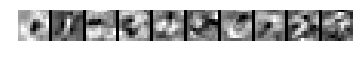

In [9]:
W = linear_classifier.coef_
ims = tri(W, (im_size, im_size), (1, 10), (1,1))
plt.imshow(ims, cmap='gray', interpolation='nearest')
plt.axis('off')

## MLP

(-0.5, 108.5, 53.5, -0.5)

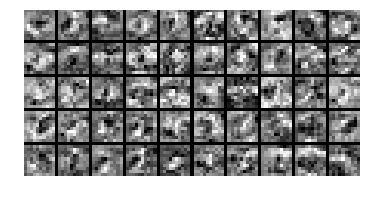

In [10]:
W = mlp.get_weights()[0].T
ims = tri(W, (im_size, im_size), (W.shape[0]//10, 10), (1,1))
plt.imshow(ims, cmap='gray', interpolation='nearest')
plt.axis('off')

## CNN

(-0.5, 58.5, 10.5, -0.5)

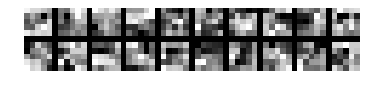

In [11]:
W = cnn.get_weights()[0]
ims = tri(W.reshape(-1, np.prod(W.shape[2:])), (W.shape[2], W.shape[3]), (W.shape[0]//10, 10), (1,1))
plt.imshow(ims, cmap='gray', interpolation='nearest')
plt.axis('off')